In [2]:
import pandas as pd 
import numpy as np

def load_data(file_path):
    selected_columns = ["db_id","question","query"]
    df = pd.read_parquet(file_path,columns=selected_columns)
    X_train = df[["db_id","question"]]
    y_train = df[["query"]]
    return X_train,y_train

X_train, y_train = load_data("/Users/jagpreetsingh/ML_Projects/text-sql/data/train/0000.parquet")

X_train['question'] = X_train["db_id"] +" "+ X_train['question']

X_train = X_train.drop('db_id',axis=1)

print(X_train.loc[:10])
print(y_train.loc[:10])



                                             question
0   department_management How many heads of the de...
1   department_management List the name, born stat...
2   department_management List the creation year, ...
3   department_management What are the maximum and...
4   department_management What is the average numb...
5   department_management What are the names of th...
6   department_management What are the distinct cr...
7   department_management What are the names of th...
8   department_management In which year were most ...
9   department_management Show the name and number...
10  department_management How many acting statuses...
                                                query
0          SELECT count(*) FROM head WHERE age  >  56
1   SELECT name ,  born_state ,  age FROM head ORD...
2   SELECT creation ,  name ,  budget_in_billions ...
3   SELECT max(budget_in_billions) ,  min(budget_i...
4   SELECT avg(num_employees) FROM department WHER...
5   SELECT name FROM head WH

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize input sequences (questions)
tokenizer_input = Tokenizer()
tokenizer_input.fit_on_texts(X_train['question'])
X_train_sequences = tokenizer_input.texts_to_sequences(X_train['question'])
X_train_padded = pad_sequences(X_train_sequences, padding='post')

print(f"X_train_padded: {X_train_padded[:10]}")

# Tokenize target sequences (SQL queries)
tokenizer_output = Tokenizer()
tokenizer_output.fit_on_texts(y_train['query'])
y_train_sequences = tokenizer_output.texts_to_sequences(y_train['query'])
y_train_padded = pad_sequences(y_train_sequences, padding='post',maxlen = X_train_padded.shape[1])

print(f"y_train_padded: {y_train_padded[:10]}")

# Vocabulary sizes
vocab_size_input = len(tokenizer_input.word_index) + 1
vocab_size_output = len(tokenizer_output.word_index) + 1

print(f"vocab_size_input: {vocab_size_input}")
print(f"vocab_size_output: {vocab_size_output}")





X_train_padded: [[  48  249   19   21  987    2    1  226    6  403   22 2579    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  48  249   24    1    9 1065  174    3   91    2    1  987    2  226
    82   27   91    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  48  249   24    1 1302   73    9    3  330    2   23   48    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  48  249    4    6    1   86    3  144  330    2    1  226    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [  48  249    4   10    1   30   14    2   72    2    1  226   42  152
    10  209  237    3  774    0    0    0    0    0    0    0    0    0
     0    0 

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_dim = 128
units = 256

model = Sequential([
    Embedding(input_dim=vocab_size_input, output_dim=embedding_dim, input_length=X_train_padded.shape[1]),
    LSTM(units, return_sequences=True),
    Dense(units=vocab_size_output, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [9]:
history = model.fit(X_train_padded, y_train_padded, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
175/175 [==============================] - 13s 71ms/step - loss: 3.3139 - accuracy: 0.5374 - val_loss: 2.9778 - val_accuracy: 0.5905
Epoch 2/5
175/175 [==============================] - 12s 71ms/step - loss: 2.5908 - accuracy: 0.5775 - val_loss: 2.8674 - val_accuracy: 0.5869
Epoch 3/5
175/175 [==============================] - 13s 74ms/step - loss: 2.4506 - accuracy: 0.5837 - val_loss: 2.8410 - val_accuracy: 0.5881
Epoch 4/5
175/175 [==============================] - 13s 73ms/step - loss: 2.3700 - accuracy: 0.5875 - val_loss: 2.8530 - val_accuracy: 0.5887
Epoch 5/5
175/175 [==============================] - 13s 74ms/step - loss: 2.3111 - accuracy: 0.5910 - val_loss: 2.8770 - val_accuracy: 0.5814


In [10]:
import matplotlib.pyplot as plt

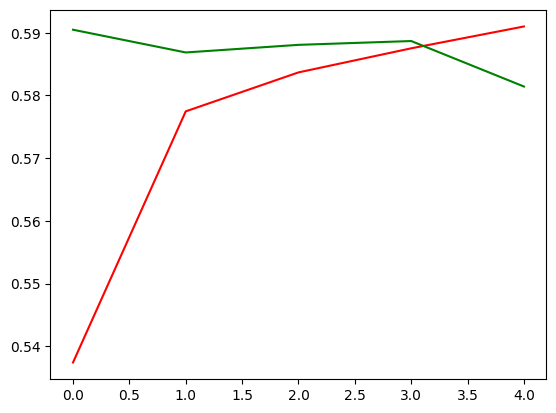

In [11]:
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')

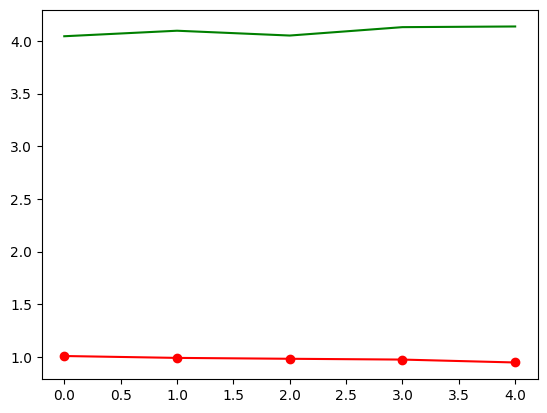

In [40]:
plt.plot(history.history['loss'],'r-o')
plt.plot(history.history['val_loss'],'g')

In [14]:
def generate_sql_sequence(question):
    question_sequence = tokenizer_input.texts_to_sequences([question])
    question_padded = pad_sequences(question_sequence, padding='post', maxlen=X_train_padded.shape[1])
    predicted_sequence = model.predict(question_padded)[0]
    print(predicted_sequence)
    predicted_sql_query = [tokenizer_output.index_word[idx] for idx in np.argmax(predicted_sequence, axis=-1) if idx != 0]
    return " ".join(predicted_sql_query)

# Example usage:
new_question = "How many heads of the departments are older than 56 ?"
predicted_sql_query = generate_sql_sequence(new_question)
print("Predicted SQL Query:", predicted_sql_query)


1/1 [==============================] - 0s 18ms/step
[[1.99953956e-03 4.84866882e-03 3.67997540e-03 ... 1.53107714e-04
  1.70387430e-04 1.78267321e-04]
 [3.99421668e-03 4.20591654e-03 3.41136963e-03 ... 1.09713117e-04
  1.09974695e-04 1.14675953e-04]
 [4.26058248e-02 1.26164397e-02 7.58398883e-03 ... 2.17981560e-05
  2.28793633e-05 2.64657465e-05]
 ...
 [9.87592280e-01 5.18529559e-04 5.33211569e-04 ... 1.50126278e-09
  1.84327353e-09 2.42343190e-09]
 [9.87607419e-01 5.17795037e-04 5.32430364e-04 ... 1.49805357e-09
  1.83942084e-09 2.41895726e-09]
 [9.87620175e-01 5.17151318e-04 5.31745842e-04 ... 1.49521828e-09
  1.83602356e-09 2.41500064e-09]]
Predicted SQL Query: select from


In [17]:
for i in range(10,16):

    question = list(X_train.iloc[i,:])[0]
    print(f"question: {question}")
    predicted_sql_query = generate_sql_sequence(question)
    actual_query = list(y_train.iloc[i,:])[0]
    
    print(f"actual query: {actual_query}")
    print(f"predicted_sql_query: {predicted_sql_query}")

question: department_management How many acting statuses are there?
1/1 [==============================] - 0s 20ms/step
actual query: SELECT count(DISTINCT temporary_acting) FROM management
predicted_sql_query: select count from from from from
question: department_management How many departments are led by heads who are not mentioned?
1/1 [==============================] - 0s 13ms/step
actual query: SELECT count(*) FROM department WHERE department_id NOT IN (SELECT department_id FROM management);
predicted_sql_query: select count from from from from as
question: department_management What are the distinct ages of the heads who are acting?
1/1 [==============================] - 0s 13ms/step
actual query: SELECT DISTINCT T1.age FROM management AS T2 JOIN head AS T1 ON T1.head_id  =  T2.head_id WHERE T2.temporary_acting  =  'Yes'
predicted_sql_query: select count from from from from from
question: department_management List the states where both the secretary of 'Treasury' department and 

In [18]:
from tensorflow.keras.models import load_model


model = load_model('artifacts/baseline.h5')


In [3]:
from gensim.models import KeyedVectors

# Load pre-trained GloVe embeddings
glove_model = KeyedVectors.

# Check if special characters have embeddings
special_characters = ['*', '(', ')', '$', '#', '@']
for char in special_characters:
    if char in glove_model:
        print(f"Embedding for '{char}': {glove_model[char]}")
    else:
        print(f"No embedding found for '{char}'")


KeyboardInterrupt: 